In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import pandas as pd

In [71]:
def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

In [72]:
def halfmoon(n_samples, epsilon):
  pts = np.linspace(0,180, n_samples//2)* np.pi / 180
  haut = np.hstack((np.cos(pts).reshape((-1,1)), np.sin(pts).reshape((-1,1))))
  bas = np.hstack((1-np.cos(pts).reshape((-1,1)), 0.5-np.sin(pts).reshape((-1,1))))
  data = np.vstack((haut,bas))
  data[:,0]+=np.random.normal(0,epsilon,n_samples)
  data[:,1]+=np.random.normal(0,epsilon,n_samples)
  y = np.zeros(n_samples)
  y[n_samples//2:]=1
  return data, y

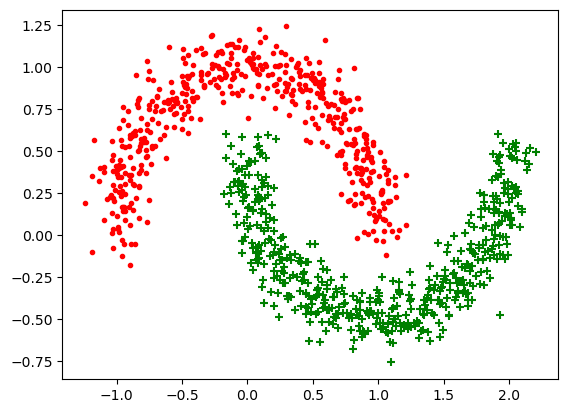

In [73]:
#Param
nbex = 1000
epsilon = 0.1

# x, y = make_moons(n_samples=nbex, noise=noise)
data, y = halfmoon(nbex, epsilon)
plot_data(data, y)

## Preparation de données

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
idx = np.arange(len(y))
idx_train_val, idx_test = train_test_split(idx, test_size=0.2, shuffle = True)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, shuffle = True)
data_train = data[idx_train]
data_val = data[idx_val]
data_test = data[idx_test]

y_train = y[idx_train]
y_val = y[idx_val]
y_test = y[idx_test]

In [76]:
def makeData(n_samples, epsilon):
    data, y = halfmoon(n_samples, epsilon)
    idx = np.arange(len(y))
    idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle = True)

    data_train = data[idx_train]
    data_test = data[idx_test]
    y_train = y[idx_train]
    y_test = y[idx_test]

    return data_train, y_train, data_test, y_test


## Apprentissage

In [77]:
from sklearn.svm import LinearSVC

In [78]:
clf = LinearSVC()
clf.fit(data_train, y_train)

/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [79]:
from sklearn.metrics import accuracy_score

In [80]:
y_pred_val = clf.predict(data_val)
accuracy_score(y_val, y_pred_val)

0.9

## Algorithme Growing Spheres

In [81]:
def generate_SL(x, ray1, ray2, n):
  d = x.shape[0]
  z = np.random.multivariate_normal(np.zeros(d),np.diag(np.ones(d)),n)
  z = (z/(np.linalg.norm(z, axis=1)).reshape((-1,1)))
  u = np.random.uniform(ray1**d, ray2**d, n)
  u = u**(1/d)
  u = u.reshape((-1,1))
  x_new = x+z*u
  return x_new

In [82]:
x = data[np.random.randint(nbex)]
x_new = generate_SL(x,2,4,100)

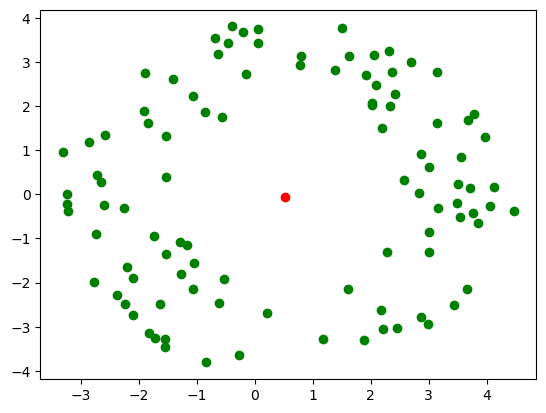

In [83]:
plt.scatter(x[0],x[1], color="red")
plt.scatter(x_new[:,0],x_new[:,1], color="green")
plt.show()

In [84]:
def GSG(clf, x, etha, n):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
  """
  f_x = clf.predict([x])[0]
  z = generate_SL(x,0,etha,n)

  while (clf.predict(z)==f_x).sum()!=n:
    etha /=2
    z = generate_SL(x,0,etha,n)

  a0 = etha
  a1 = 2*etha

  while (clf.predict(z)==f_x).sum()==n:
    z = generate_SL(x,a0,a1,n)
    a0 = a1
    a1 += etha
  z = z[clf.predict(z)!=f_x]
  idx_min = np.argmin(np.linalg.norm(x-z, axis=1))
  return z[idx_min]

def GSFS(clf, x, etha, n):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
  """
  f_x = clf.predict([x])
  e = GSG(clf, x, etha, n)
  e_tmp = np.copy(e)
  e_target = None
  while clf.predict([e_tmp]) != f_x:
    e_target = np.copy(e_tmp) #deep copy ici
    features_idx = np.where(e_tmp!=x)[0]
    i = features_idx[np.argmin(np.abs(e_tmp[features_idx]-x[features_idx]))]
    e_tmp[i] = x[i]
  return e, e_target


In [85]:
from sklearn.inspection import DecisionBoundaryDisplay

In [86]:
def visualisation_2D(data, y, clf, x, GS, etha=5, n=50) -> None:
  """
    Params:
      data: données
      y   : labels des données
      clf : un classfifier
      x   : un point de départ dont point cicle nous voulons chercher
      GS  : une fonction qui genère le point cible selon Algorithme Growing Spheres
      etha: hyperparamètre, rayon de recherche
      n   : hyperparamètre, nombre de données générés à chaque itération
  """
  disp = DecisionBoundaryDisplay.from_estimator(
      clf, data, response_method="predict",
      xlabel="X", ylabel="Y",
      alpha=0.5)

  disp.ax_.scatter(data[:, 0], data[:, 1], c=y, edgecolor="k",alpha=0.2)
  disp.ax_.scatter(x[0], x[1], color="red", label="point choisi")

  if GS.__name__ == "GSG":
    e = GS(clf, x, etha, n)
    disp.ax_.scatter(e[0], e[1], color=np.random.rand(1,3), label="cible_"+GS.__name__)
    plt.title("Growing Spheres Generation")
  else:
    e, e_modif = GS(clf, x, etha, n)
    disp.ax_.scatter(e[0], e[1], color=np.random.rand(1,3), label="cible_GSG")
    disp.ax_.scatter(e_modif[0], e_modif[1], color=np.random.rand(1,3), label="cible_GSFS")
    plt.title("Growing Spheres Feature Selection")
  plt.legend()
  plt.show()

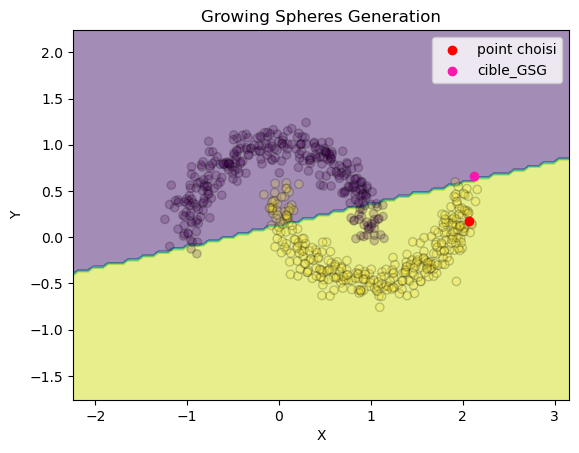

In [87]:
x = data[np.random.randint(nbex)]
GS = GSG
visualisation_2D(data_train, y_train, clf, x, GS)

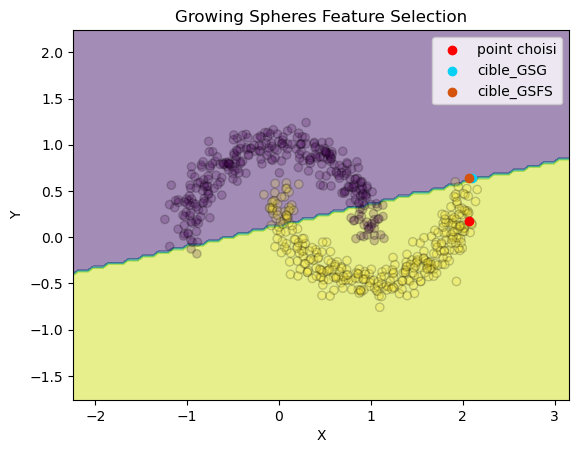

In [88]:
GS = GSFS
visualisation_2D(data_train, y_train, clf, x, GS)

## Expérimentation

### Robustesse selon classifieur utilisé

/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` e

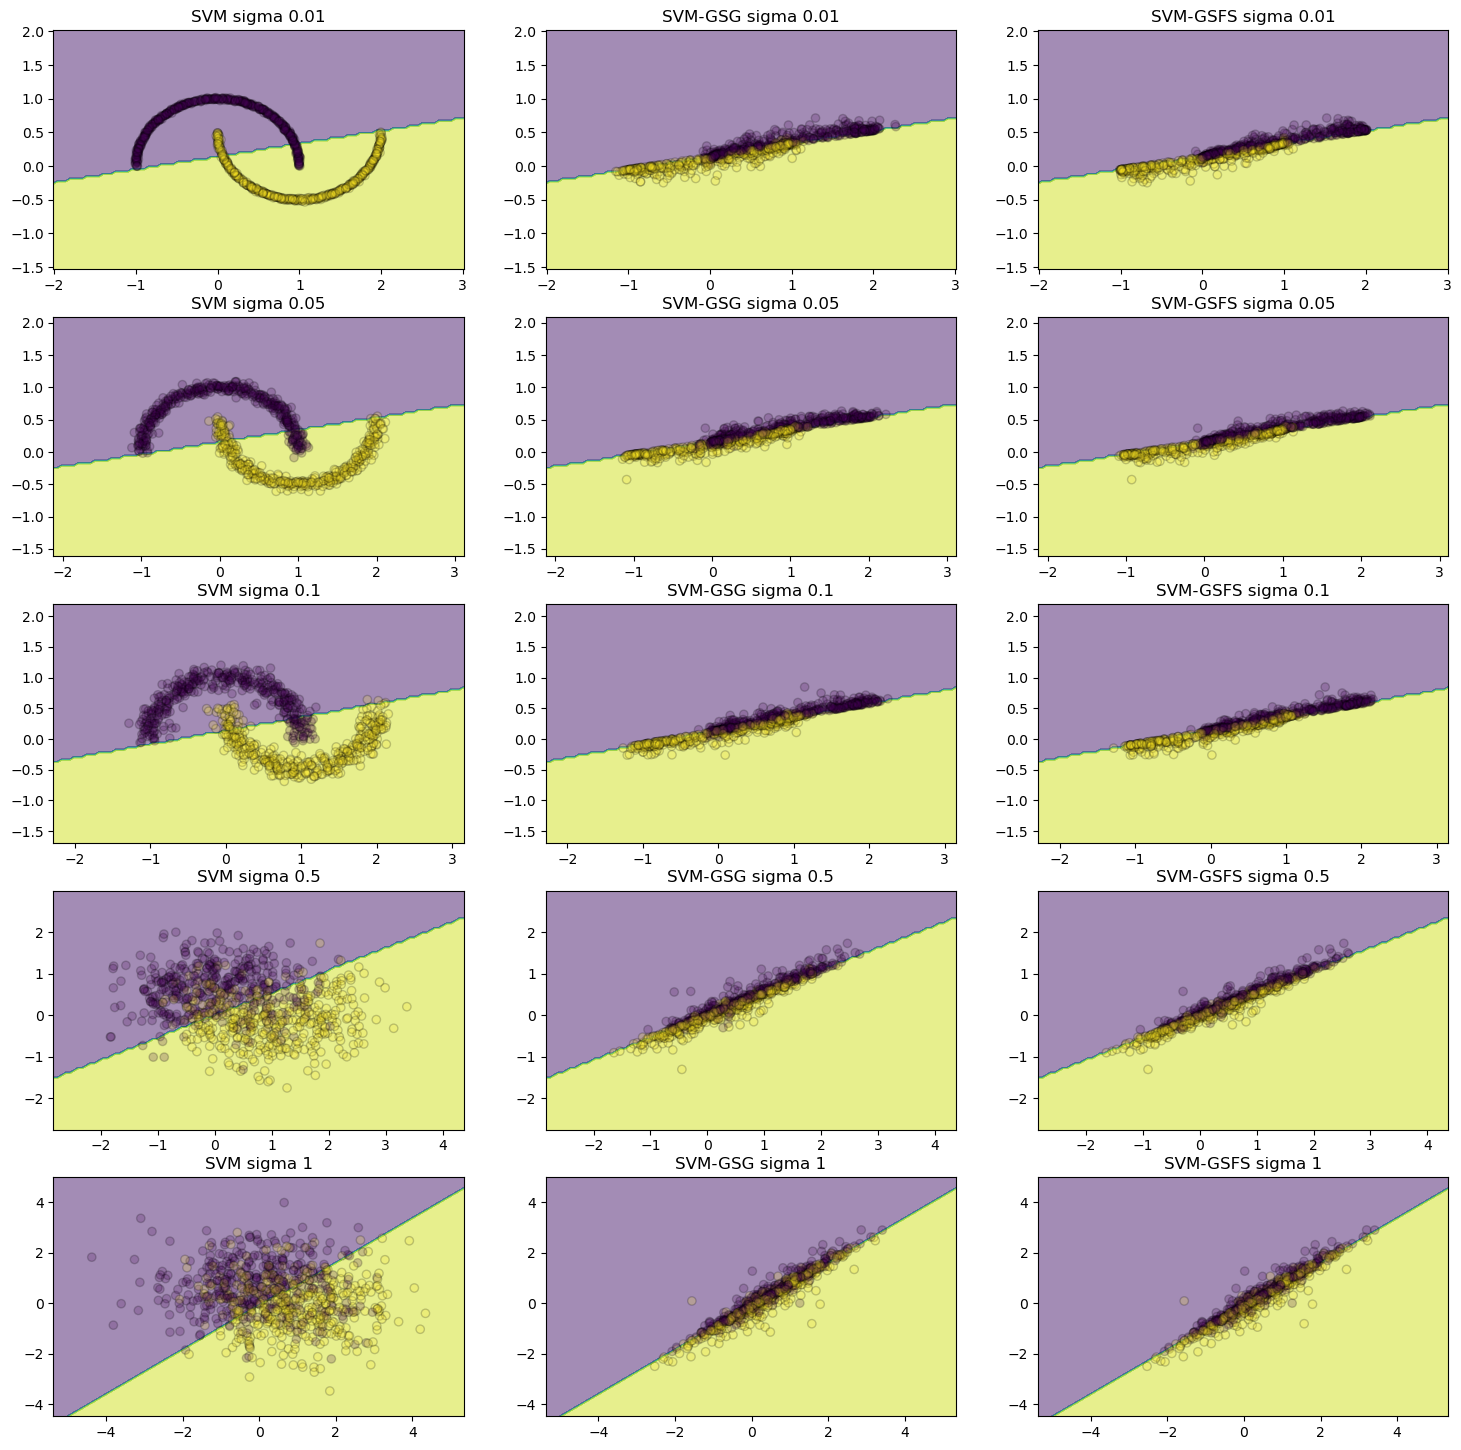

In [89]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon=[0.01, 0.05, 0.1, 0.5, 1]
nbex = 1000
clf = LinearSVC()
dist = []

for eps in epsilon:
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=eps)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSG sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSFS sigma {epsilon[i//3]}')
    i+=1

    dist.append([eps, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [90]:
pd_dist = pd.DataFrame(dist, columns=['sigma', 'GSG', 'GSFS'])
pd_dist

sigma       GSG      GSFS
0   0.01  0.589166  0.574368
1   0.05  0.581877  0.567757
2   0.10  0.599242  0.586177
3   0.50  0.812629  0.808410
4   1.00  1.218668  1.217839

In [91]:
from sklearn.ensemble import RandomForestClassifier


In [92]:
data_train, y_train, data_test, y_test = makeData(n_samples=1000, epsilon=0.03)

In [93]:
clf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 1)
clf.fit(data_train, y_train)
accuracy_score(y_test, clf.predict(data_test))


0.995

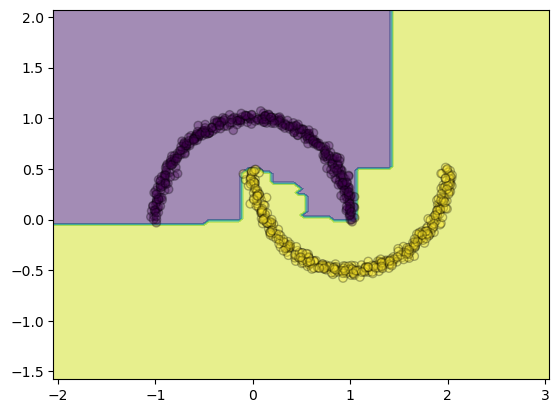

In [94]:
disp = DecisionBoundaryDisplay.from_estimator(clf,
        data_train,
        response_method="predict",
        alpha=0.5)
disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train,edgecolor="k", alpha=0.3)

### Robustesse sur la perturbation de données 

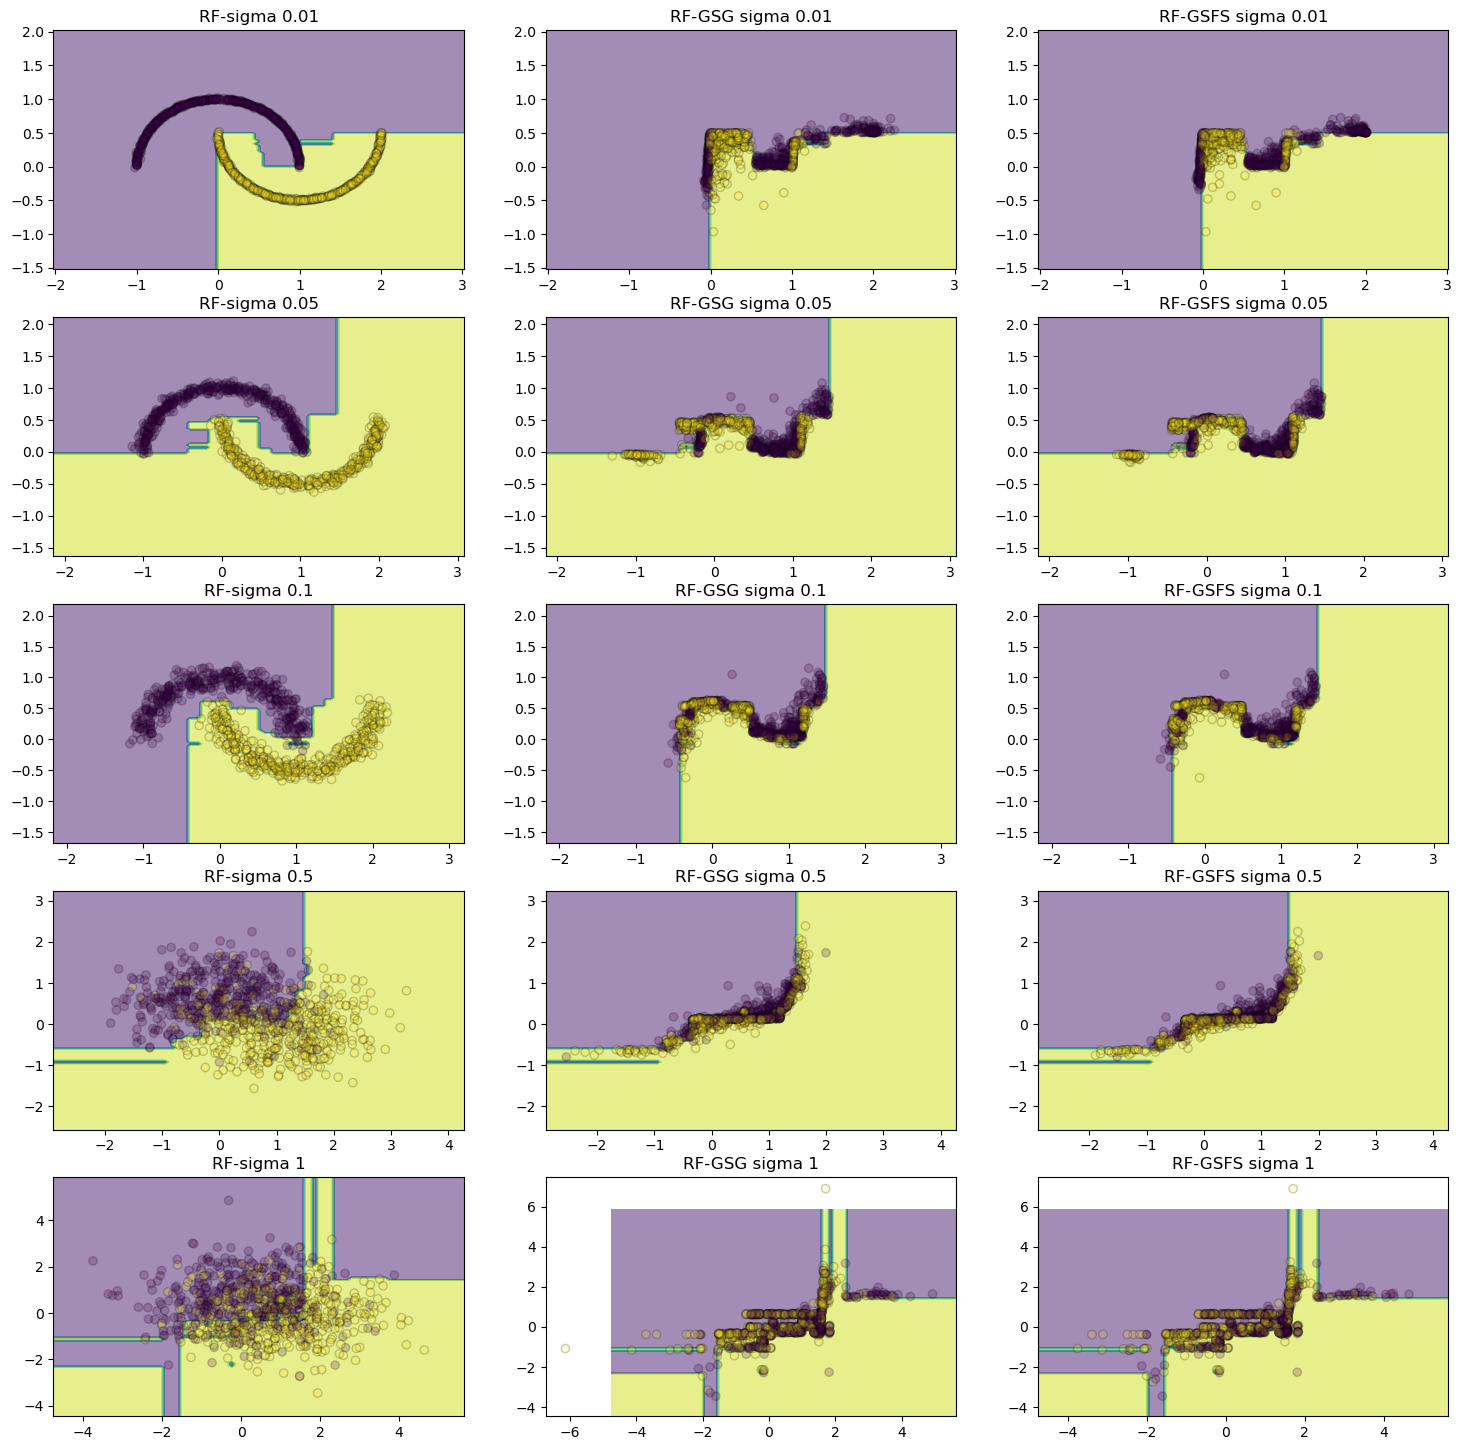

In [95]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon=[0.01, 0.05, 0.1, 0.5, 1]
nbex = 1000
dist = []
clf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 1)

for eps in epsilon:
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=eps)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-GSG sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-GSFS sigma {epsilon[i//3]}')
    i+=1
    dist.append([eps, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [96]:
pd_dist = pd.DataFrame(dist, columns=['sigma', 'GSG', 'GSFS'])
pd_dist

sigma       GSG      GSFS
0   0.01  0.551749  0.541849
1   0.05  0.503961  0.496461
2   0.10  0.522206  0.514227
3   0.50  0.734846  0.722025
4   1.00  0.713721  0.697751

In [97]:
from sklearn.neighbors import KNeighborsClassifier

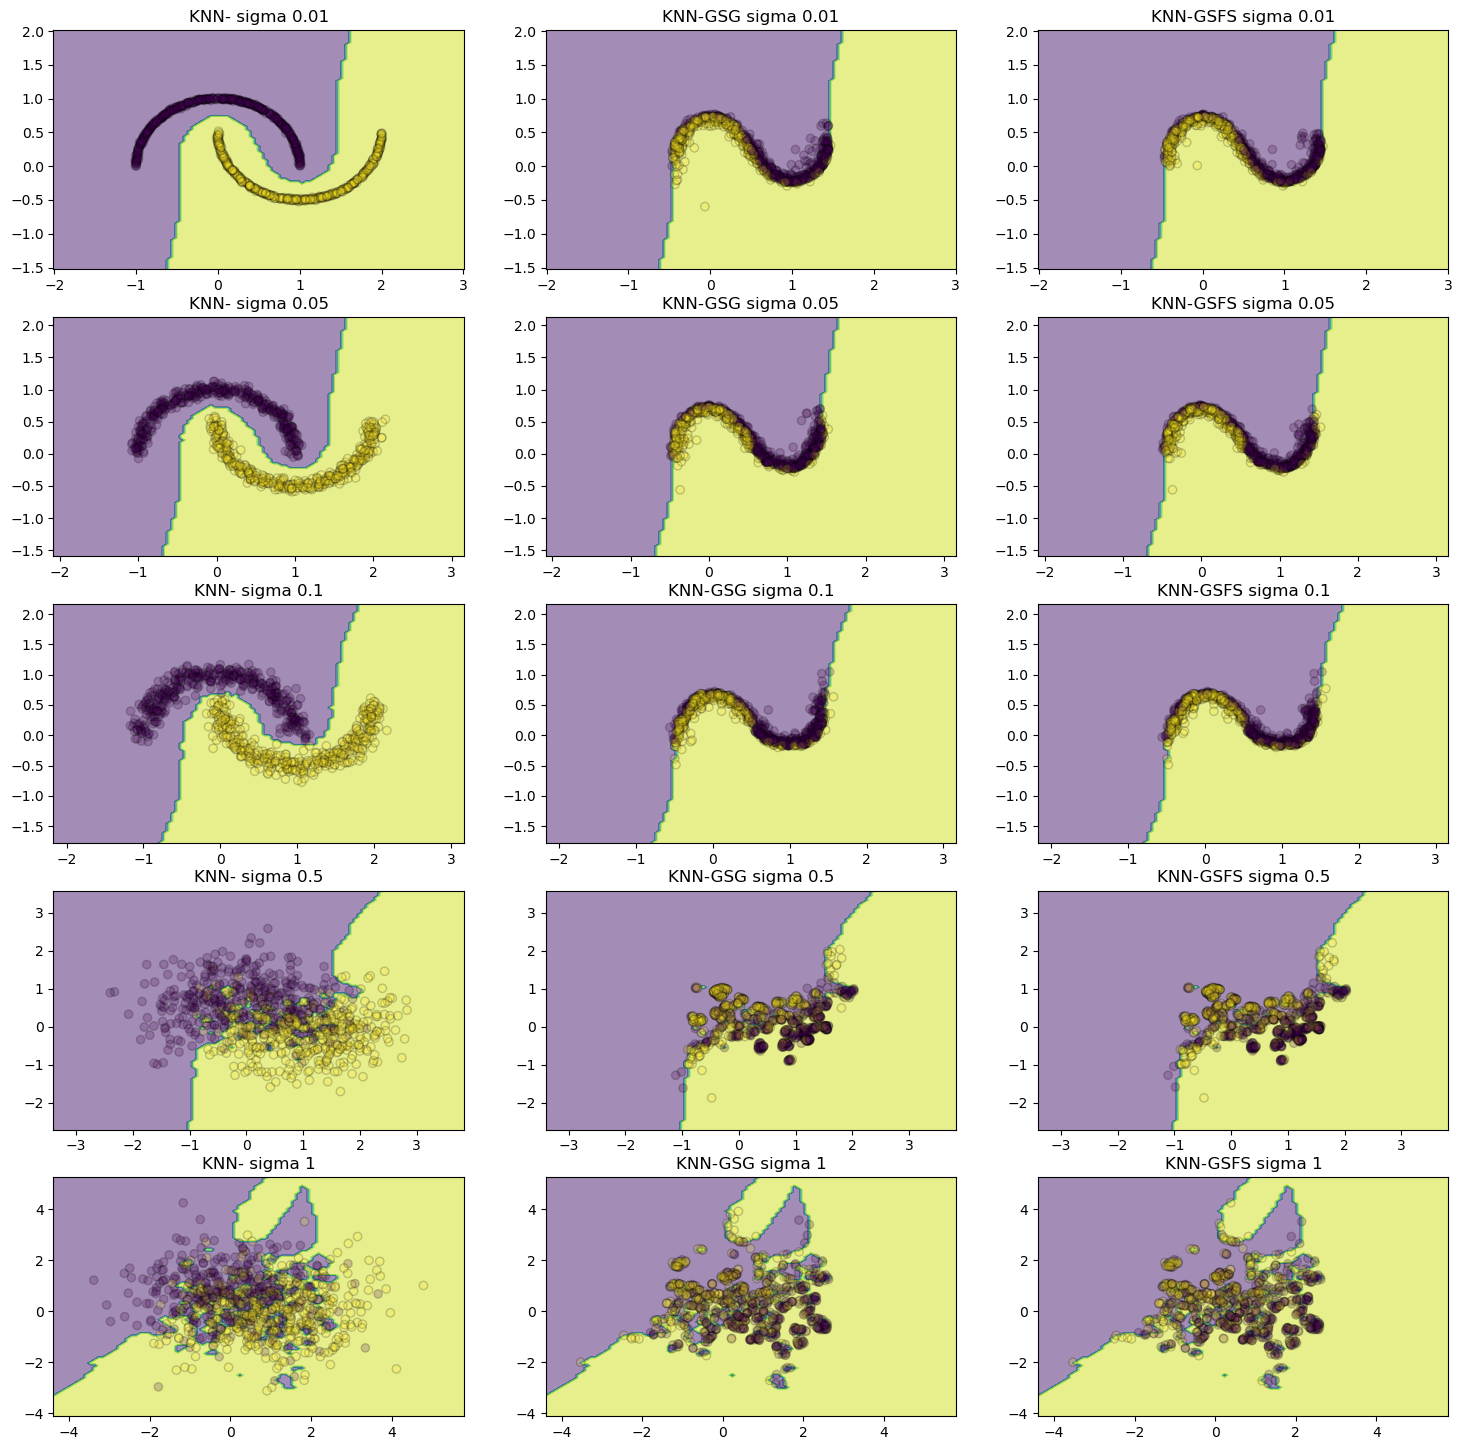

In [98]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon=[0.01, 0.05, 0.1, 0.5, 1]
nbex = 1000
clf = KNeighborsClassifier(n_neighbors=3)
dist = []
for eps in epsilon:
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=eps)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN- sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSG sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSFS sigma {epsilon[i//3]}')
    i+=1
    dist.append([eps, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [99]:
pd_dist = pd.DataFrame(dist, columns=['sigma', 'GSG', 'GSFS'])
pd_dist

sigma       GSG      GSFS
0   0.01  0.430972  0.425780
1   0.05  0.438982  0.434644
2   0.10  0.456958  0.452491
3   0.50  0.445583  0.441771
4   1.00  0.260923  0.257590

### Modification sur la complexité de classifieur

In [100]:
from sklearn.svm import SVC

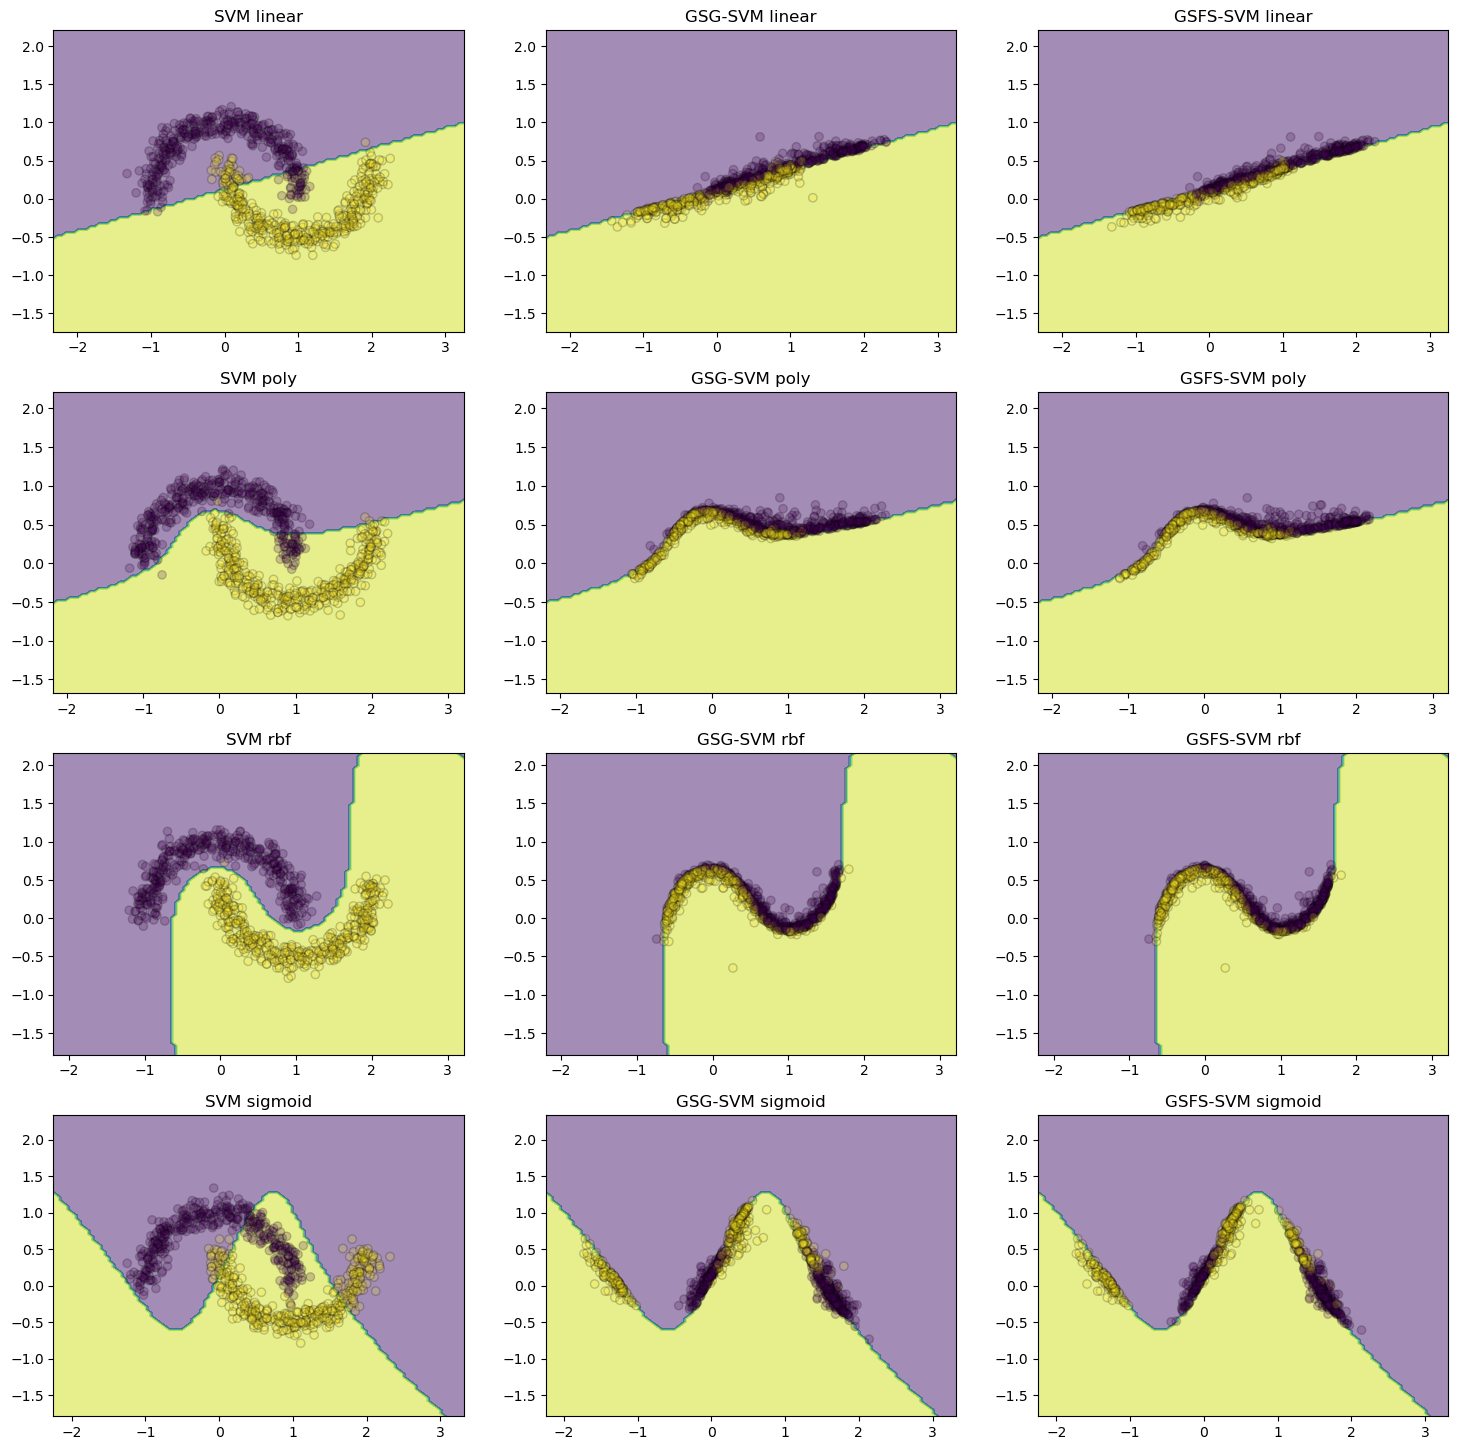

In [101]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
kernels = ["linear", "poly", "rbf", "sigmoid"]
dist =[]
for k in kernels:
    clf = SVC(kernel=k, random_state=1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM {k}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSG-SVM {k}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSFS-SVM {k}')
    i+=1
    dist.append([k, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [102]:
pd_dist = pd.DataFrame(dist, columns=['kernel', 'GSG', 'GSFS'])
pd_dist

kernel       GSG      GSFS
0   linear  0.631226  0.620112
1     poly  0.514883  0.505355
2      rbf  0.441361  0.437924
3  sigmoid  0.484732  0.482681

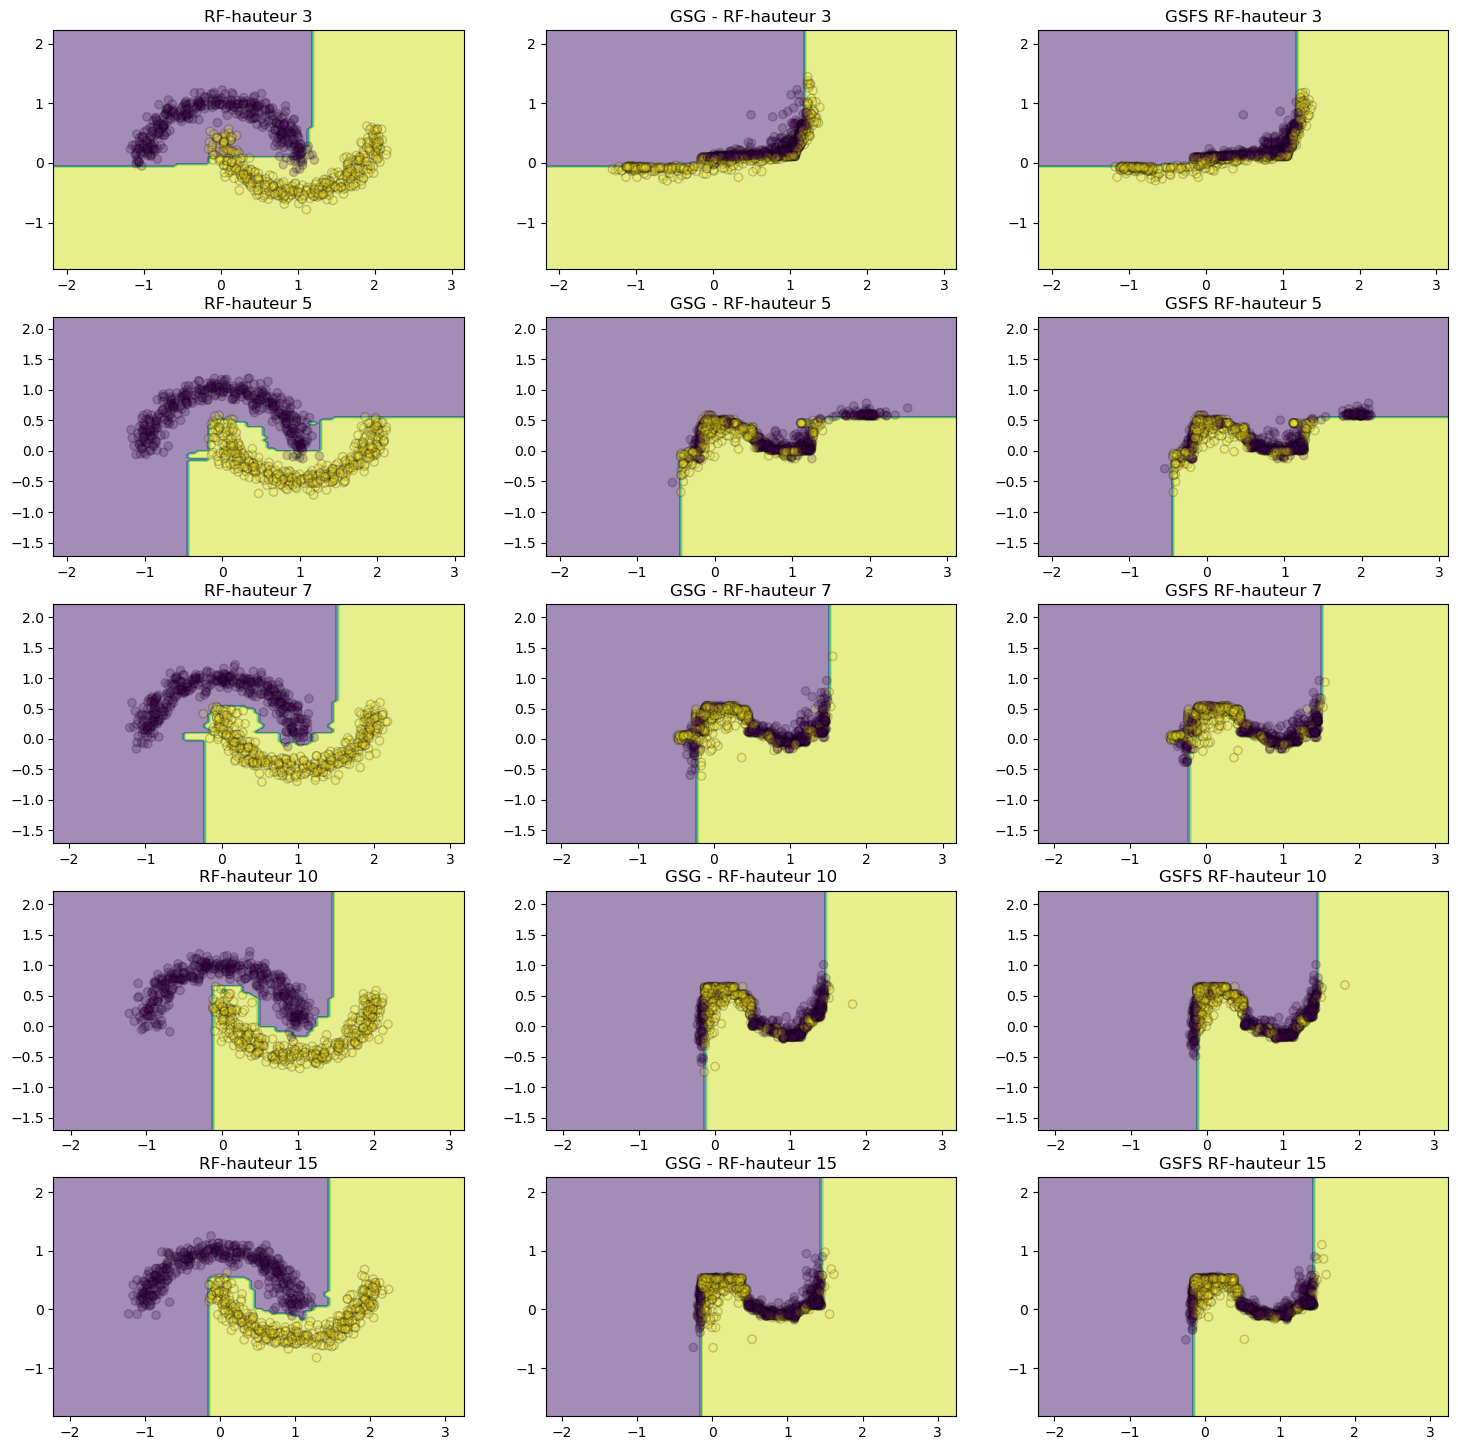

In [103]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
depths = [3, 5, 7, 10, 15]
dist = []
for d in depths:
    clf = RandomForestClassifier(n_estimators = 10, max_depth = d, random_state = 1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-hauteur {d}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSG - RF-hauteur {d}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSFS RF-hauteur {d}')
    i+=1
    dist.append([d, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])
    

In [104]:
pd_dist = pd.DataFrame(dist, columns=['hauteur', 'GSG', 'GSFS'])
pd_dist

hauteur       GSG      GSFS
0        3  0.645602  0.629699
1        5  0.514897  0.507540
2        7  0.518227  0.510810
3       10  0.478688  0.471854
4       15  0.513345  0.502113

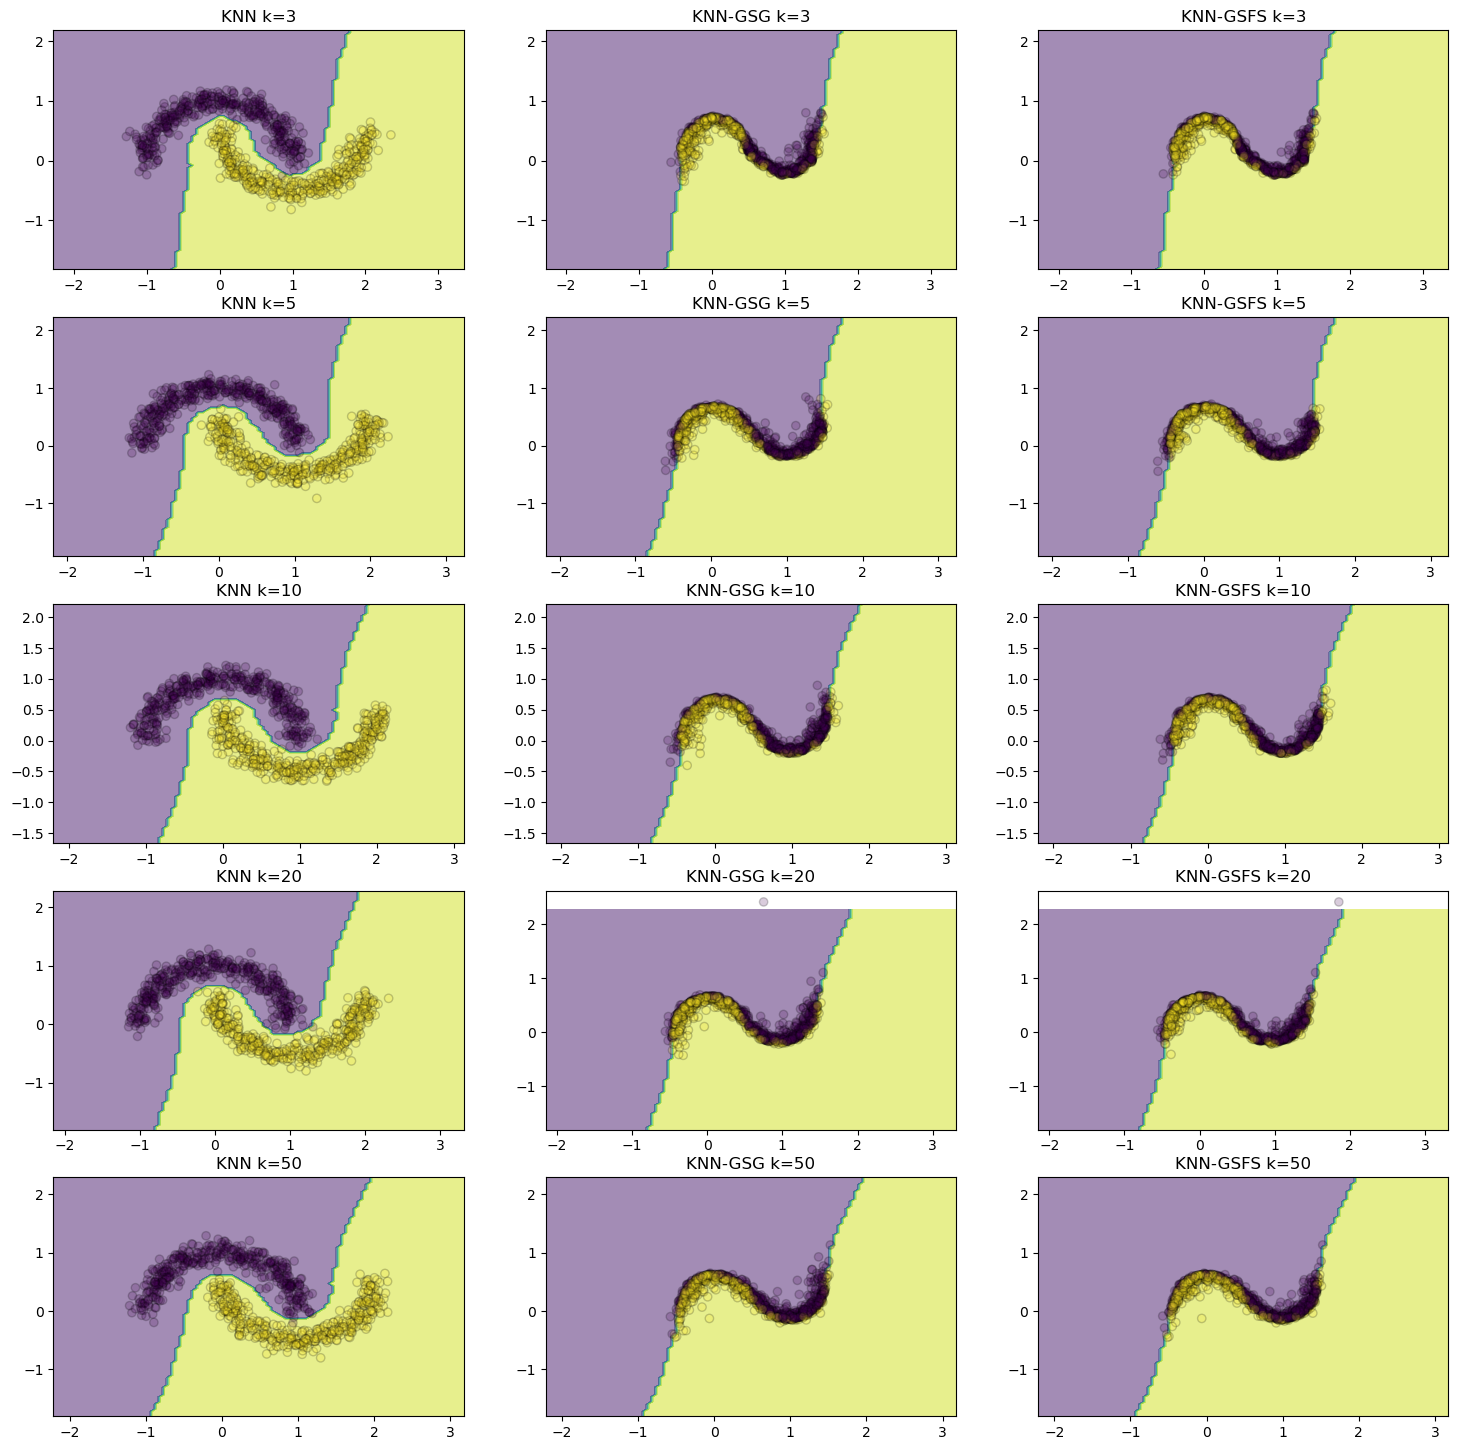

In [105]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
ks=[3, 5, 10, 20, 50]
nbex = 1000
dist = []

for k in ks:
    #Classifieur
    clf = KNeighborsClassifier(n_neighbors=k)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN k={k}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSG k={k}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSFS k={k}')
    i+=1
    dist.append([k, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [106]:
pd_dist = pd.DataFrame(dist, columns=['k', 'GSG', 'GSFS'])
pd_dist

k       GSG      GSFS
0   3  0.449687  0.444383
1   5  0.463522  0.458379
2  10  0.458845  0.453364
3  20  0.481630  0.476021
4  50  0.485119  0.479451

### Modification les paramètres de l'algorithme

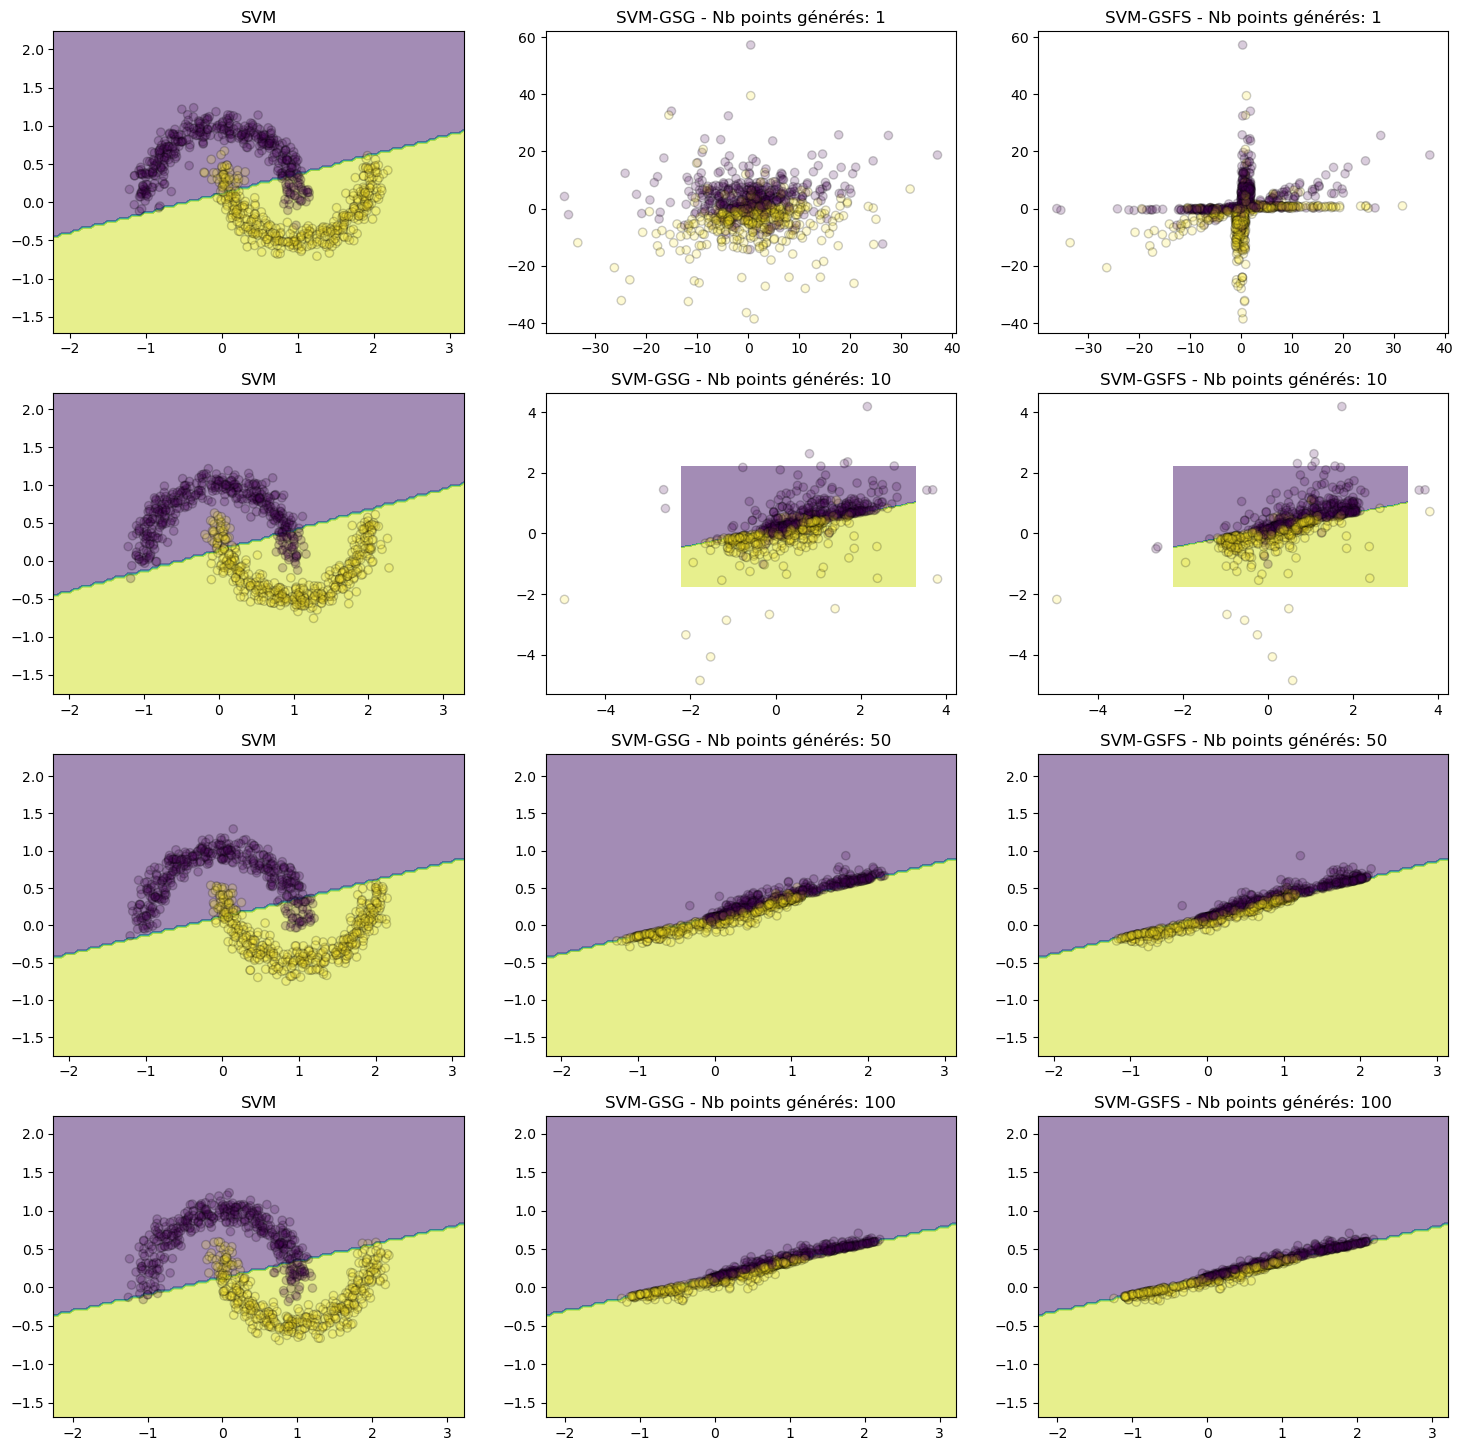

In [107]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
nb_gen = [1, 10, 50, 100]
dist = []
for n in nb_gen:
    clf = SVC(kernel="linear", random_state=1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=n) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSG - Nb points générés: {n}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSFS - Nb points générés: {n}')
    i+=1
    dist.append([n, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [108]:
pd_dist = pd.DataFrame(dist, columns=['nbGen', 'GSG', 'GSFS'])
pd_dist

nbGen       GSG      GSFS
0      1  9.398748  8.694886
1     10  0.957070  0.906306
2     50  0.613906  0.602906
3    100  0.567495  0.561372

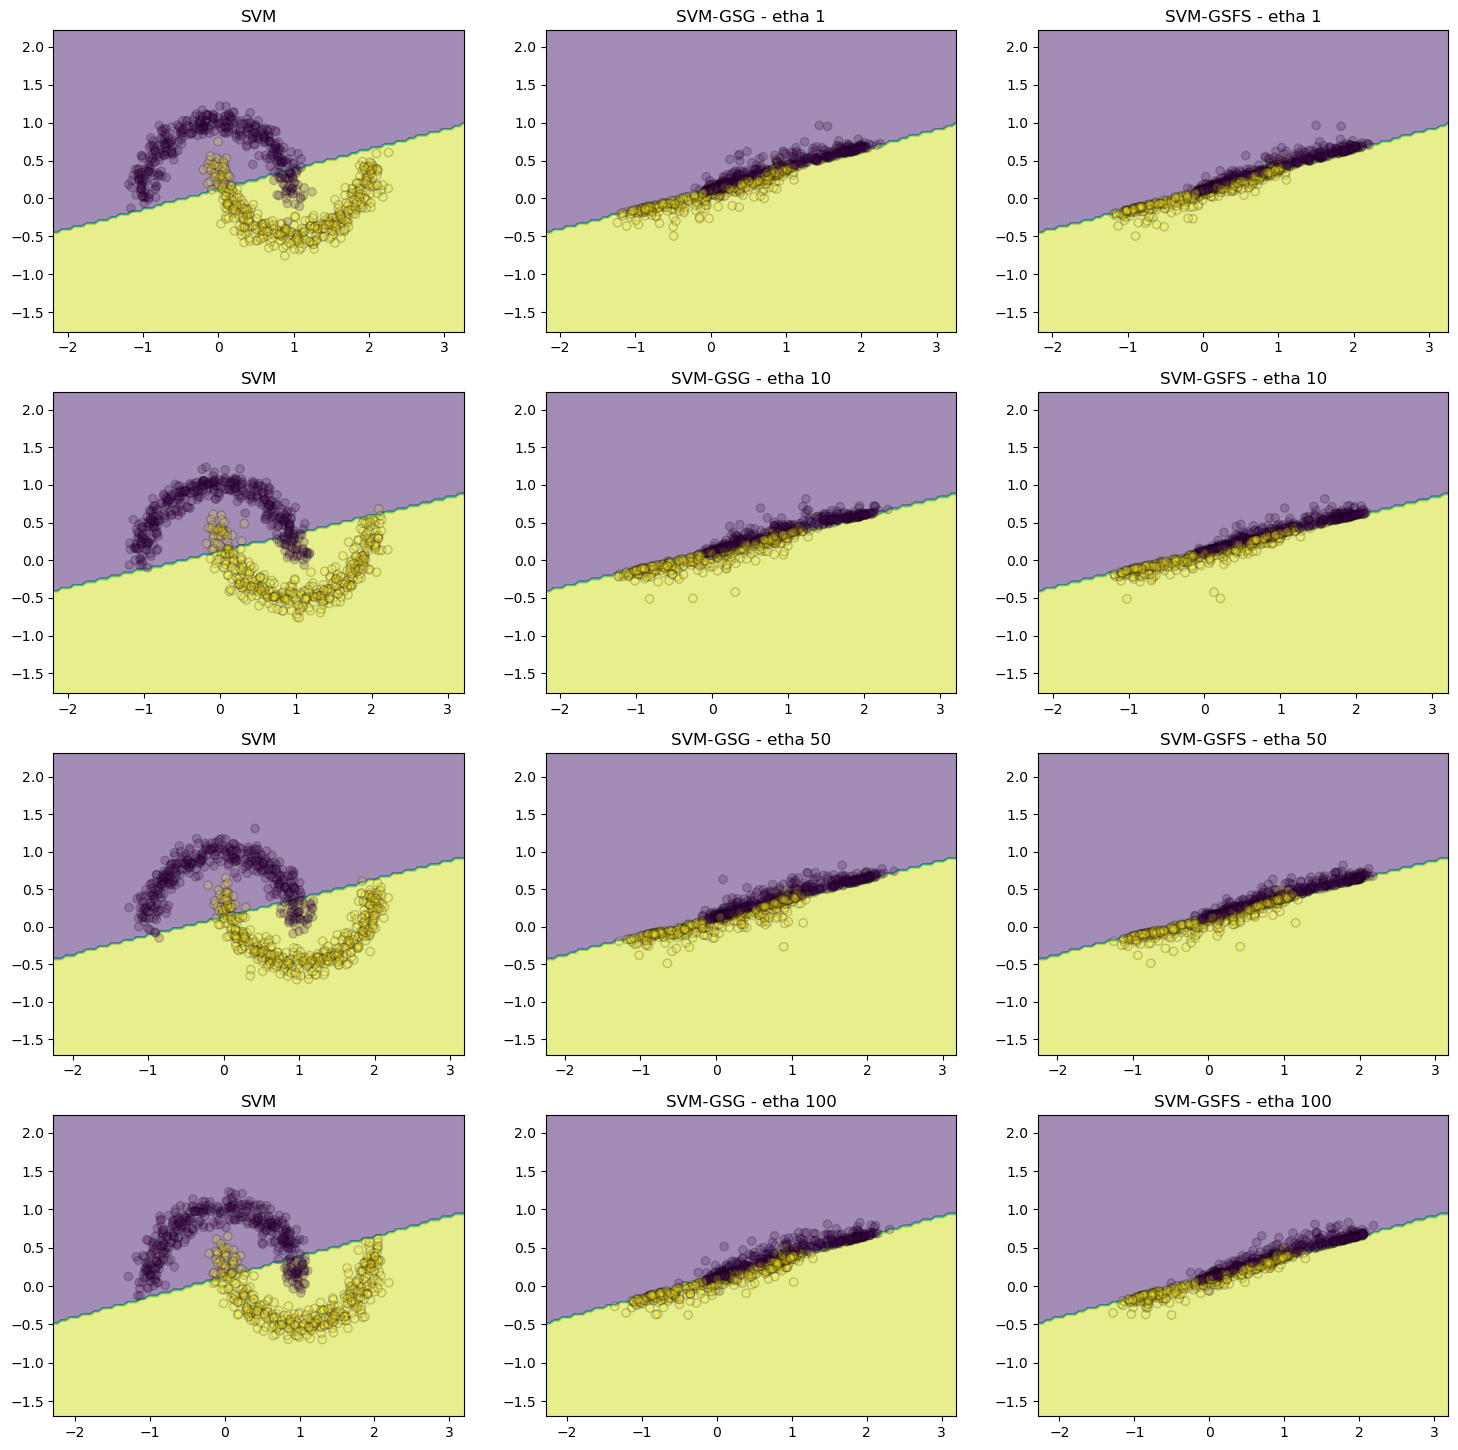

In [109]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
ethas = [1, 10, 50, 100]
dist = []
for etha in ethas:
    clf = SVC(kernel="linear", random_state=1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=etha, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSG - etha {etha}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSFS - etha {etha}')
    i+=1
    dist.append([etha, np.linalg.norm(data_train-e_GSG, axis=1).mean(), np.linalg.norm(data_train-e_GSFS, axis=1).mean()])

In [110]:
pd_dist = pd.DataFrame(dist, columns=['etha', 'GSG', 'GSFS'])
pd_dist

etha       GSG      GSFS
0     1  0.635228  0.622443
1    10  0.622652  0.610560
2    50  0.624773  0.610627
3   100  0.633289  0.619847

## Breast cancer Wisconsin

In [235]:
data_wine_path = 'data/winequality-red.csv'
data_cancer_path = 'data/brca.csv'

In [266]:
df = pd.read_csv(data_wine_path)
# df = pd.read_csv(data_cancer_path, index_col=0)

In [267]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [268]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [269]:
df.quality.value_counts()


5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [270]:
df['quality'] = np.where(df['quality'] >= 7, 1, 0)

In [271]:
df.quality.value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [272]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [273]:
def prepare_X(df):
    return df.values

In [274]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

y_train = df_train.quality.values
y_test = df_test.quality.values

del df_train['quality']
del df_test['quality']

x_train = prepare_X(df_train)
x_test = prepare_X(df_test)

In [276]:
# classe desequilibree
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [315]:
clf = RandomForestClassifier(n_estimators=50, random_state=24)
clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=24)

In [316]:
accuracy_score(y_test, clf.predict(x_test))

0.8875

In [317]:
np.random.seed(0)
x = df.sample()
x_data = prepare_X(x.drop(columns=['quality']))
clf.predict(x_data)[0]

0

In [318]:
x_data = prepare_X(x.drop(columns=['quality']))
clf.predict(x_data)[0]

0

In [319]:
cf_x = [GSG(clf, x_data[0], etha=10, n=50) for i in range(5)]

df_cf = pd.DataFrame(cf_x, columns=df_train.columns)
df_cf['quality'] = clf.predict(cf_x)[0]

In [320]:
x

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1109           10.8              0.47         0.43             2.1      0.171   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1109                 27.0                  66.0   0.9982  3.17       0.76   

      alcohol  quality  
1109     10.8        0

In [321]:
df_cf

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -7.915639          9.579575     0.102541       -9.135564 -32.560906   
1       4.190817          3.320167    -3.862137        9.649022  -8.473747   
2       3.736506          0.403722   -21.821304        7.809650 -20.828433   
3      36.189271        -16.980433    13.409969       44.774691   6.922964   
4       4.650009         20.605108   -19.741636      -18.956467  -5.401887   

   free sulfur dioxide  total sulfur dioxide    density         pH  sulphates  \
0            49.127793             66.013609 -15.555393  -9.040974  19.813945   
1            20.672633             66.503592  -3.509096   4.424530   0.785939   
2            53.012113             95.481136 -32.382664 -26.880311  -7.279732   
3             7.079564              7.644800 -52.476510  40.536565  38.417577   
4            32.627853             86.630621 -22.866901  -8.370275   4.699145   

     alcohol  quality  
0  42.556834        1  
1  17.705917        1  
2  14.148392        1  
3  50.674722        1  
4  22.648588        1

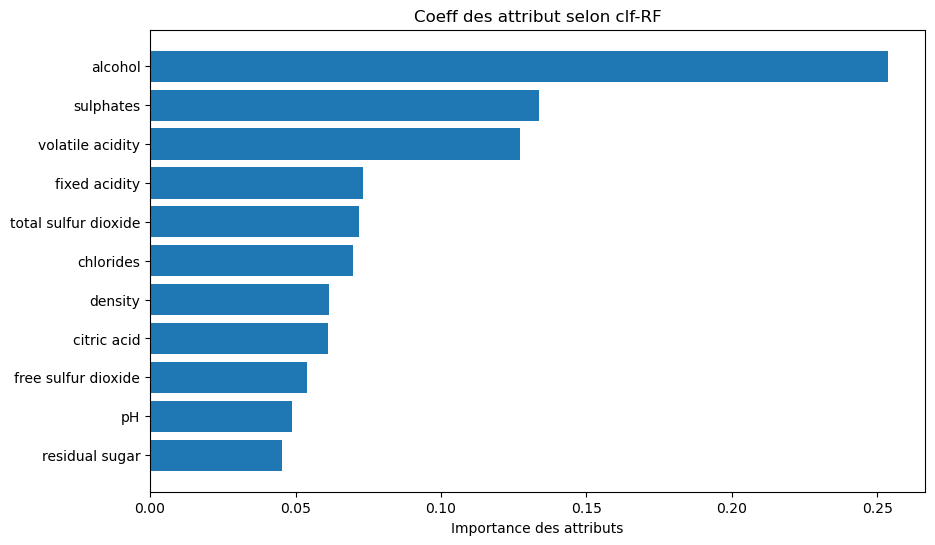

In [322]:
# Coeff des attributs
att_coeff = clf.feature_importances_
att_names = df_train.columns

# Trier
sorted_idx = att_coeff.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), att_coeff[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [att_names[i] for i in sorted_idx])
plt.xlabel('Importance des attributs')
plt.title('Coeff des attribut selon clf-RF')
plt.show()